In [1]:
import os
import json
import random
import pandas as pd
from collections import Counter

# ---------------- CONFIG ----------------
INPUT_JSON = "../data/raw/data.json"
OUTPUT_CSV = "../data/processed/balanced_dataset.csv"
RANDOM_STATE = 42
MIN_TARGET = 750
MAX_TARGET = 800
# ----------------------------------------

random.seed(RANDOM_STATE)

# ---- Load JSON ----
print("Loading data from", INPUT_JSON)
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print("Initial records:", len(df))
print("Initial label counts:", Counter(df["label"]))
df.head()


Loading data from ../data/raw/data.json
Initial records: 10848
Initial label counts: Counter({'normal': 7855, 'anxiety': 1139, 'depression': 1136, 'suicidal': 718})


,id,title,selftext,subreddit,label,score,created_utc
0,1n9305g,Life's boring asf,I am totally convinced that there's no solutio...,depression,normal,1,1.757073e+09
1,1n92zn4,"I feel dead, yet more alive than ever",have you ever felt like you're in some sort of...,depression,normal,1,1.757073e+09
2,1n92wh9,Someone please tell me what to do,I accidentally just pulled an all nighter and ...,depression,normal,2,1.757072e+09
3,1n9215x,"Everyone tells me I'm going great, but my life...",I'm f24. I have a bf m28.\n\nBoth of us live w...,depression,anxiety,3,1.757070e+09
4,1n920r8,boredom again,i just read a post that was about that eternal...,depression,normal,1,1.757070e+09


In [2]:
# ---- Cleaning ----
def clean_data(df):
    df = df.dropna(subset=["title", "selftext"])
    df = df[(df["title"].str.strip() != "") & (df["selftext"].str.strip() != "")]
    return df.reset_index(drop=True)

df = clean_data(df)
print("After cleaning:", len(df))
print("Label counts after cleaning:", Counter(df["label"]))
df.head()


After cleaning: 10235
Label counts after cleaning: Counter({'normal': 7252, 'depression': 1136, 'anxiety': 1129, 'suicidal': 718})


,id,title,selftext,subreddit,label,score,created_utc
0,1n9305g,Life's boring asf,I am totally convinced that there's no solutio...,depression,normal,1,1.757073e+09
1,1n92zn4,"I feel dead, yet more alive than ever",have you ever felt like you're in some sort of...,depression,normal,1,1.757073e+09
2,1n92wh9,Someone please tell me what to do,I accidentally just pulled an all nighter and ...,depression,normal,2,1.757072e+09
3,1n9215x,"Everyone tells me I'm going great, but my life...",I'm f24. I have a bf m28.\n\nBoth of us live w...,depression,anxiety,3,1.757070e+09
4,1n920r8,boredom again,i just read a post that was about that eternal...,depression,normal,1,1.757070e+09


In [3]:
# ---- Downsampling ----
balanced_parts = []
labels = df["label"].unique()

for label in labels:
    subset = df[df["label"] == label]
    count = len(subset)

    if label == "suicidal":
        print(f"Keeping all {count} suicidal posts")
        balanced_parts.append(subset)
    else:
        target = random.randint(MIN_TARGET, MAX_TARGET)
        if count > target:
            subset = subset.sample(n=target, random_state=RANDOM_STATE)
            print(f"Downsampled {label}: {count} -> {target}")
        else:
            print(f"Label {label} has only {count}, below target {target}. Keeping all.")
        balanced_parts.append(subset)

balanced_df = pd.concat(balanced_parts, axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)


Downsampled normal: 7252 -> 790
Downsampled anxiety: 1129 -> 757
Keeping all 718 suicidal posts
Downsampled depression: 1136 -> 751


In [4]:
# ---- Save Final CSV ----
balanced_df = balanced_df[["id", "title", "selftext", "label"]]

os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
balanced_df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

print("\n✅ Balanced dataset saved to:", OUTPUT_CSV)
print("Final label counts:", Counter(balanced_df["label"]))
balanced_df.head()



✅ Balanced dataset saved to: ../data/processed/balanced_dataset.csv
Final label counts: Counter({'normal': 790, 'anxiety': 757, 'depression': 751, 'suicidal': 718})


,id,title,selftext,label
0,1mg7mpq,I used to scam people and i scammed a girl tha...,"( i typed this message almost a year ago , the...",normal
1,1n8rg56,I don't know if I have depression,I was recently kicked out of school and have b...,depression
2,1n7yii5,Are people actually happy with life?,Ive never felt true happiness in my life for a...,normal
3,1j9q5g9,Embarassed to meet my friends because I do not...,I'm 26f. One of my friends who lives abroad is...,depression
4,1my3p4i,"Anyone else find the rise of ""you don't owe an...",It seems to be frequently framed in a positive...,normal


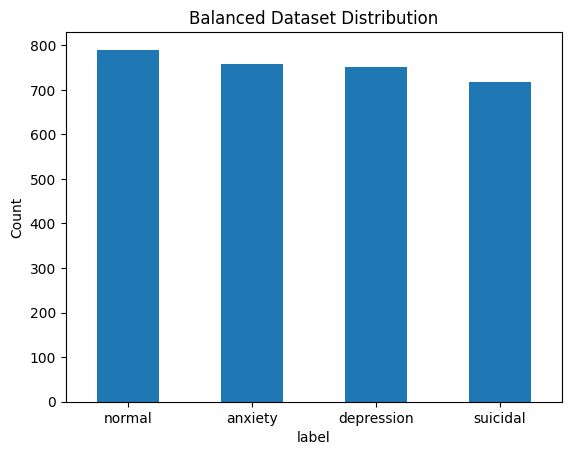

In [6]:
import matplotlib.pyplot as plt

balanced_df["label"].value_counts().plot(kind="bar", rot=0)
plt.title("Balanced Dataset Distribution")
plt.ylabel("Count")
plt.show()
